In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

#import torchvision
#from torchvision import datasets
#from torchvision import transforms
#from torchvision.utils import save_image
#from torchsummary import summary

#from pushover import notify
#from utils import makegif
from random import randint

from IPython.display import Image, clear_output
from IPython.core.display import Image, display

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [111]:
ims = []
files = ["./models/" + x for x in os.listdir("./models") if "cam" in x]

for i, file in enumerate(files):
    clear_output(wait=True)
    print(i)
    with open(file, "rb") as f:
        ims.append(plt.imread(f, format="jpeg"))

23123


In [83]:
def gs(im):
     #return 1 / (1 + np.exp(cv2.resize(np.dot(im[:, :, :3], [0.299, 0.587, 0.114]), (64, 64))))
    return cv2.resize(np.dot(im[:, :, :3], [0.299, 0.587, 0.114]), (64, 64)) / 255

In [112]:
im_tensors = [torch.FloatTensor(gs(x)[np.newaxis]).to(device) for x in ims]

In [113]:
dataloader = torch.utils.data.DataLoader(im_tensors, batch_size = 64, shuffle=True)

In [114]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [115]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [128]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        ).to(device)
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        ).to(device)
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [129]:
model = VAE(image_channels=1).to(device)

In [130]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [131]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [132]:
epochs = 50
bs = 64

In [133]:
for epoch in range(epochs):
    for idx, images in enumerate(dataloader):
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, loss.item()/bs, bce.item()/bs, kld.item()/bs)
        print(to_print)

# notify to android when finished training
notify(to_print, priority=1)

torch.save(vae.state_dict(), 'vae.torch')

/u/70/viitala1/unix/miniconda3/envs/donkey/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/50] Loss: 2857.805 2857.805 0.000
Epoch[1/50] Loss: 2825.220 2825.220 0.000
Epoch[1/50] Loss: 2729.207 2729.204 0.003
Epoch[1/50] Loss: 3095.341 3095.308 0.033
Epoch[1/50] Loss: 2676.977 2676.972 0.005
Epoch[1/50] Loss: 2743.461 2743.459 0.001
Epoch[1/50] Loss: 2762.428 2762.428 0.000
Epoch[1/50] Loss: 2773.895 2773.895 0.000
Epoch[1/50] Loss: 2773.870 2773.870 0.000
Epoch[1/50] Loss: 2769.917 2769.917 0.000
Epoch[1/50] Loss: 2762.323 2762.323 0.000
Epoch[1/50] Loss: 2749.855 2749.855 0.000
Epoch[1/50] Loss: 2732.821 2732.821 0.000
Epoch[1/50] Loss: 2709.780 2709.780 0.000
Epoch[1/50] Loss: 2684.258 2684.258 0.000
Epoch[1/50] Loss: 2672.785 2672.785 0.000
Epoch[1/50] Loss: 2672.938 2672.938 0.000
Epoch[1/50] Loss: 2624.047 2624.047 0.000
Epoch[1/50] Loss: 2637.201 2637.201 0.000
Epoch[1/50] Loss: 2665.536 2665.536 0.000
Epoch[1/50] Loss: 2617.634 2617.634 0.000
Epoch[1/50] Loss: 2627.787 2627.787 0.000
Epoch[1/50] Loss: 2589.494 2589.494 0.000
Epoch[1/50] Loss: 2597.094 2597.09

KeyboardInterrupt: 

In [102]:
model.forward(im_tensors[0][np.newaxis, :])

(tensor([[[[0.4932, 0.4963, 0.4905,  ..., 0.4786, 0.4708, 0.4810],
           [0.4936, 0.4934, 0.4929,  ..., 0.4727, 0.4796, 0.4813],
           [0.5067, 0.5010, 0.5038,  ..., 0.4866, 0.4837, 0.4932],
           ...,
           [0.5264, 0.5265, 0.5136,  ..., 0.7738, 0.7543, 0.7648],
           [0.5130, 0.5163, 0.5129,  ..., 0.7557, 0.7226, 0.7037],
           [0.5072, 0.5083, 0.5096,  ..., 0.7526, 0.7008, 0.7661]]]],
        grad_fn=<SigmoidBackward>),
 tensor([[-0.2283,  0.4210,  0.0715, -0.2191,  0.2294, -0.7504, -0.3335, -0.0112,
           1.2602, -0.8062,  0.5384, -0.0958, -0.7722,  0.0946, -0.7384,  0.4140,
           1.1782, -1.6755,  0.1186,  0.0904, -0.7525, -0.3300,  0.7440,  0.6597,
           0.1206, -0.7003,  0.7525,  0.2263, -0.7096, -0.2456, -0.2867,  1.1247]],
        grad_fn=<AddmmBackward>),
 tensor([[ -9.6982,  -8.5687,  -8.9664,  -8.6228,  -9.0395,  -8.7256,  -9.1301,
           -8.4622,  -8.5363,  -8.1339,  -9.0064,  -9.0796,  -9.2540,  -9.9134,
           -8.9623,

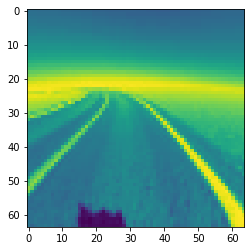

In [135]:
plt.imshow(im_tensors[0].detach().to("cpu").squeeze())

In [136]:
z, mu, logvar = model.forward(im_tensors[0][np.newaxis, :])

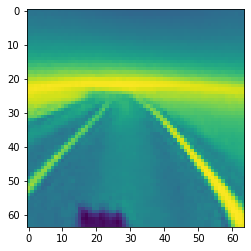

In [138]:
plt.imshow(z.detach().to("cpu").squeeze())

In [88]:
import vae
import os

import numpy as np
import random

from IPython.display import clear_output

import matplotlib.pyplot as plt

In [2]:
ims = []
files = ["./models/" + x for x in os.listdir("./models") if "cam" in x]

for i, file in enumerate(files):
    clear_output(wait=True)
    print(i)
    with open(file, "rb") as f:
        ims.append(plt.imread(f, format="jpeg"))


print(len(ims))

23123
23124


In [298]:
from importlib import reload
reload(vae)

<module 'vae' from '/m/home/home7/70/viitala1/data/Documents/Dippa/RLDonkey/vae.py'>

In [302]:
var = vae.VAE(linear_input = 1000, linear_output=20,batch_size=64, image_channels=3, lr=0.001)

In [303]:
l = len(ims)
#l = 100
for i in range(l):
    var.add_image(ims[i])

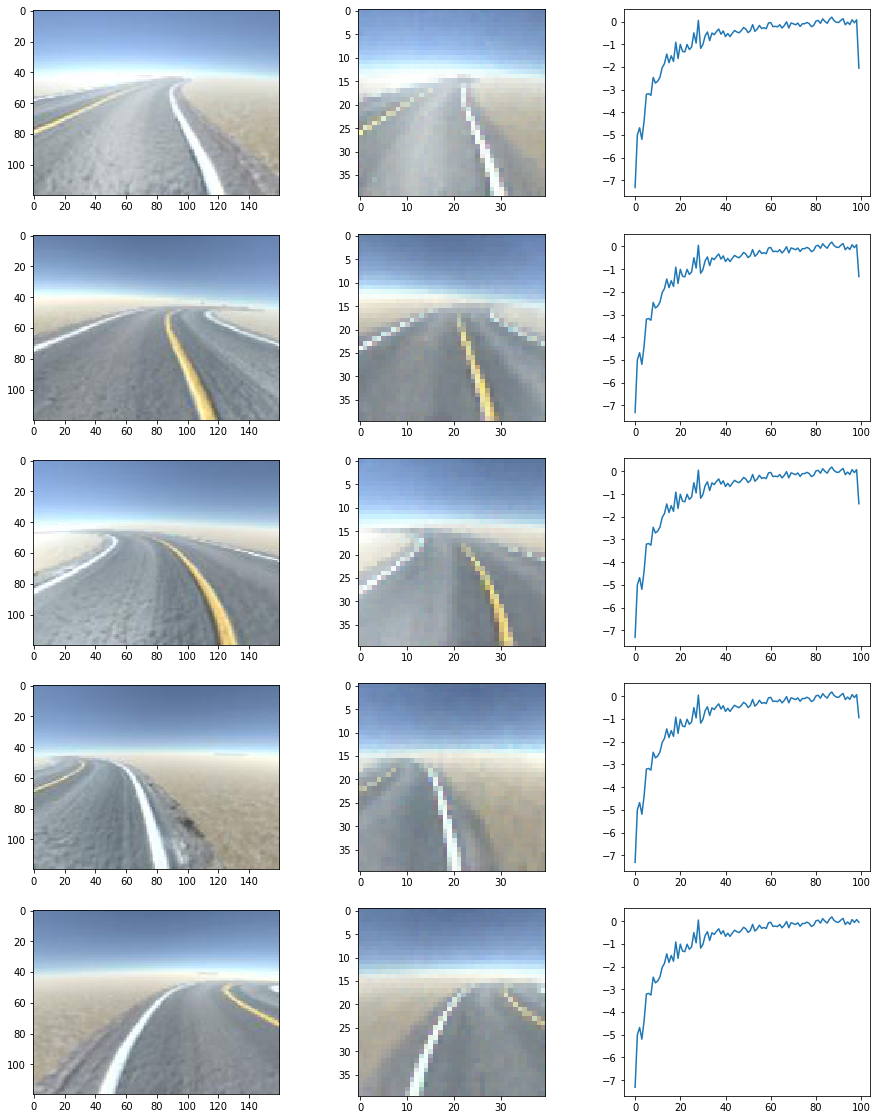

99


In [304]:
episodes = 100

embeddings = [np.ones(10)]
diffs = np.zeros(episodes)
test_size = 5
test_ims = random.sample(ims, test_size)
for i in range(episodes):
    
    #for j in random.sample(ims, 100):
    #    var.add_image(j)
        
    var.update_parameters(1, len(var.images))
    
    
    clear_output(wait = True)
    for k in range(test_size):
        im = test_ims[k]

        embedding = var.embed(im)
        decoded = var.decode(embedding[np.newaxis, np.newaxis, :]).reshape(40, 40, 3)

        #print((embedding - embeddings[i - 1]) / embedding)
        diffs[i] += (np.sum(embedding)) / test_size
        #embeddings.append(embedding)

        

        plt.figure(1, (15, 20))
        plt.subplot(test_size, 3, k * 3 + 1)
        plt.imshow(im)
        plt.subplot(test_size, 3, k * 3 + 2)
        plt.imshow(decoded)
        plt.subplot(test_size, 3, k * 3 + 3)
        plt.plot(diffs)
    plt.show()
        
    print(i)
    

In [305]:
torch.save(var, "vae.pth")

In [172]:
!du vae.pth

890496	vae.pth


In [249]:
float(not 1.0)

0.0

In [170]:
import torch

In [108]:
%%time
embedding = var.embed(ims[0]/255)[np.newaxis, np.newaxis, :]

CPU times: user 1.07 ms, sys: 22.9 ms, total: 23.9 ms
Wall time: 20.9 ms


In [241]:
a = {}

In [242]:
a["lörs"]

KeyError: 'lörs'

In [254]:
a = np.arange(5)

In [255]:
b = np.arange(2)

In [256]:
a

array([0, 1, 2, 3, 4])

In [257]:
b

array([0, 1])

In [261]:
a = np.roll(a, 1)

In [262]:
a

array([4, 0, 1, 2, 3])

In [263]:
a[:2] = b

In [264]:
a

array([0, 1, 1, 2, 3])

In [159]:
np.zeros(19)[1]

0.0

In [109]:
embedding

array([[[-0.29693386,  0.35584623, -0.54502356,  1.4411294 ,
         -0.5182079 ,  2.0483067 , -1.3810587 ,  1.567367  ,
          1.1523893 ,  1.3867122 ]]], dtype=float32)

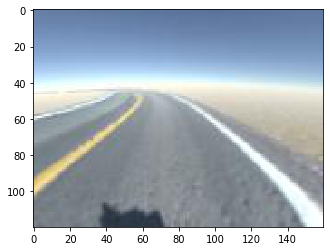

In [110]:
plt.imshow(ims[0])

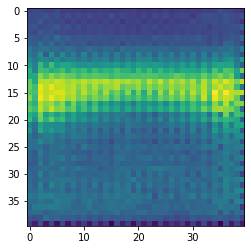

In [111]:
plt.imshow(var.decode(embedding).squeeze())

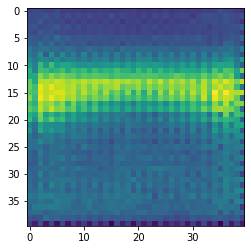

In [112]:
plt.imshow(var.decode(embedding).squeeze())

In [50]:
embedding.shape

(1, 1, 10)

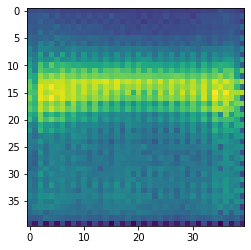

In [114]:
plt.imshow(var.decode(np.random.randn(1,1, 10)).squeeze())#[np.newaxis, np.newaxis, :]))

In [454]:
var.decode(embedding).squeeze()

array([[0.9999862 , 0.9999881 , 0.9999999 , ..., 1.        , 0.9999864 ,
        1.        ],
       [0.99999917, 1.        , 1.        , ..., 1.        , 1.        ,
        0.9999604 ],
       [0.9999999 , 0.9999999 , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.9999994 ],
       [0.99999154, 0.9999964 , 1.        , ..., 1.        , 0.9999813 ,
        1.        ],
       [0.9999831 , 0.99996686, 1.        , ..., 0.99999976, 0.9999995 ,
        0.99997306]], dtype=float32)

In [402]:
embedding.shape

(1, 1, 10)

In [22]:
def gs(im):
     return np.dot(im[40:, :, :3], [0.299, 0.587, 0.114])

In [18]:
gs_ims = [gs(x) for x in ims]

NameError: name 'np' is not defined